# CLASSIFICATION MODEL

### Prepare Library, Parameters, and Dependencies

In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import cv2
import itertools
import os

%matplotlib inline

In [ ]:
# UNCOMMENT THIS IF YOU USE GOOGLE COLAB

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check TensorFlow Version and GPU Availability
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.14.0
Num GPUs Available:  1


In [ ]:
# Set Parameters
DATASET_DIR = "/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/classification_datasets/cataract_dataset_mixed_blended/"
TEST_PREDICT_DIR = "/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict/"

BATCH_SIZE = 8
VAL_RATIO = 0.3
SHUFFLE_BUFFER_SIZE = 1100

IMG_HEIGHT = 128
IMG_WIDTH = 128

SHUFFLE_VALUE = True
AUTOTUNE = tf.data.AUTOTUNE

### Load & Split Dataset

In [ ]:
# Make Train Dataset
train_ds = keras.utils.image_dataset_from_directory(
    directory=DATASET_DIR,
    validation_split=VAL_RATIO,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_VALUE,
)

# Make Validation Dataset
val_ds = keras.utils.image_dataset_from_directory(
    directory=DATASET_DIR,
    validation_split=VAL_RATIO,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_VALUE,
)

# Make Test Dataset
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 3)
val_ds = val_ds.skip(val_batches // 3)

# Print Dataset Information
print(f'Number of training batches: {len(np.concatenate([i for x, i in train_ds]))}')
print(f'Number of validation batches: {len(np.concatenate([i for x, i in val_ds]))}')
print(f'Number of test batches: {len(np.concatenate([i for x, i in test_ds]))}')

Found 1164 files belonging to 3 classes.
Using 815 files for training.
Found 1164 files belonging to 3 classes.
Using 349 files for validation.
Number of training batches: 815
Number of validation batches: 237
Number of test batches: 112


['mild', 'normal', 'severe']


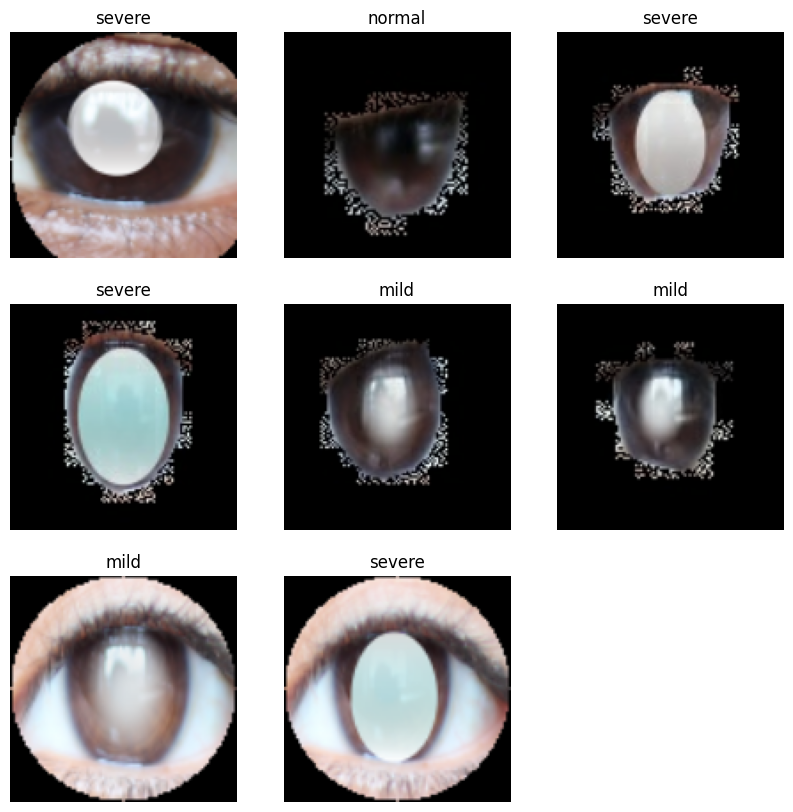

In [ ]:
# Return Class Names from Dataset
class_names = train_ds.class_names
print(class_names)

# Visualize Classification Dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Data Augmentation & Preparation

In [ ]:
# Augmentation Sequential
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip(mode='horizontal'),
    keras.layers.RandomRotation(factor=0.4),
    keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
])

### Dataset Pipelining

In [ ]:
train_ds = train_ds.cache().shuffle(SHUFFLE_BUFFER_SIZE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Callbacks

In [ ]:
stop_callback = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')

### Model Architecture #1 (CNN Vanilla)

In [ ]:
# Build Model
model = tf.keras.Sequential([
    keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    data_augmentation,
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(len(class_names))
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)      

### Train Model #1

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30
    # callbacks=[myCallback()]
)

Epoch 1/30
102/102 [==============================] - 14s 17ms/step - loss: 3.3363 - accuracy: 0.4172 - val_loss: 0.8233 - val_accuracy: 0.6287
Epoch 2/30
102/102 [==============================] - 1s 9ms/step - loss: 0.6853 - accuracy: 0.7362 - val_loss: 0.4103 - val_accuracy: 0.8354
Epoch 3/30
102/102 [==============================] - 1s 9ms/step - loss: 0.6913 - accuracy: 0.7374 - val_loss: 0.4548 - val_accuracy: 0.8312
Epoch 4/30
102/102 [==============================] - 1s 9ms/step - loss: 0.6476 - accuracy: 0.7436 - val_loss: 0.4660 - val_accuracy: 0.8354
Epoch 5/30
102/102 [==============================] - 1s 9ms/step - loss: 0.5659 - accuracy: 0.7730 - val_loss: 0.4126 - val_accuracy: 0.8481
Epoch 6/30
102/102 [==============================] - 1s 9ms/step - loss: 0.5355 - accuracy: 0.8012 - val_loss: 0.5578 - val_accuracy: 0.8228
Epoch 7/30
102/102 [==============================] - 1s 9ms/step - loss: 0.4792 - accuracy: 0.8061 - val_loss: 0.4537 - val_accuracy: 0.8523
Epoc

### Evaluate Model With Test Dataset

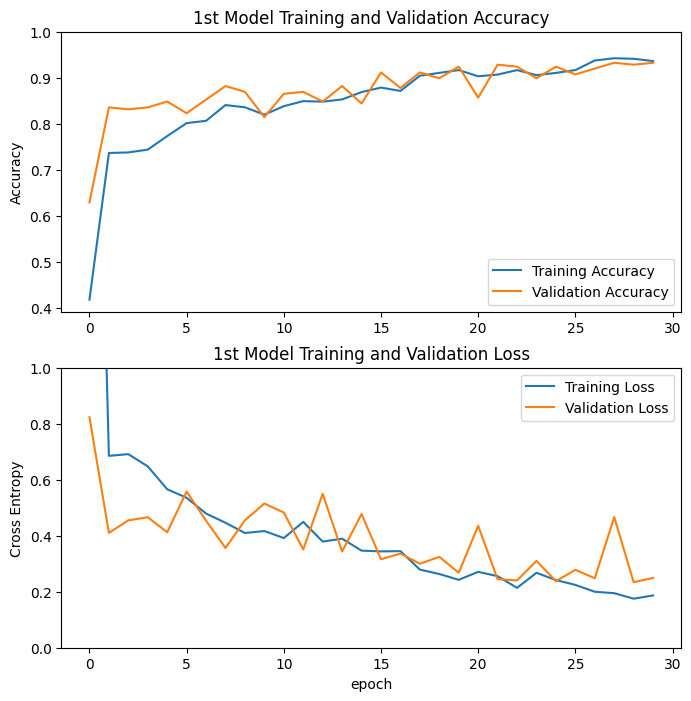

In [ ]:
# Retrieve Accuracy and Loss from Classification Model
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('1st Model Training and Validation Accuracy')

# Plot Loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('1st Model Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Evaluate Model
loss, accuracy = model.evaluate(test_ds)

14/14 [==============================] - 0s 5ms/step - loss: 0.2139 - accuracy: 0.9464


In [ ]:
# Retrieve a True Label from the Test Dataset
y_true = np.concatenate([i for x, i in test_ds])

# Make Prediction
y_pred = np.argmax(model.predict(test_ds), axis=-1)

# Plot Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

14/14 [==============================] - 0s 2ms/step


In [ ]:
# Plot Function Confusion Matrix
def show_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontsize=15)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

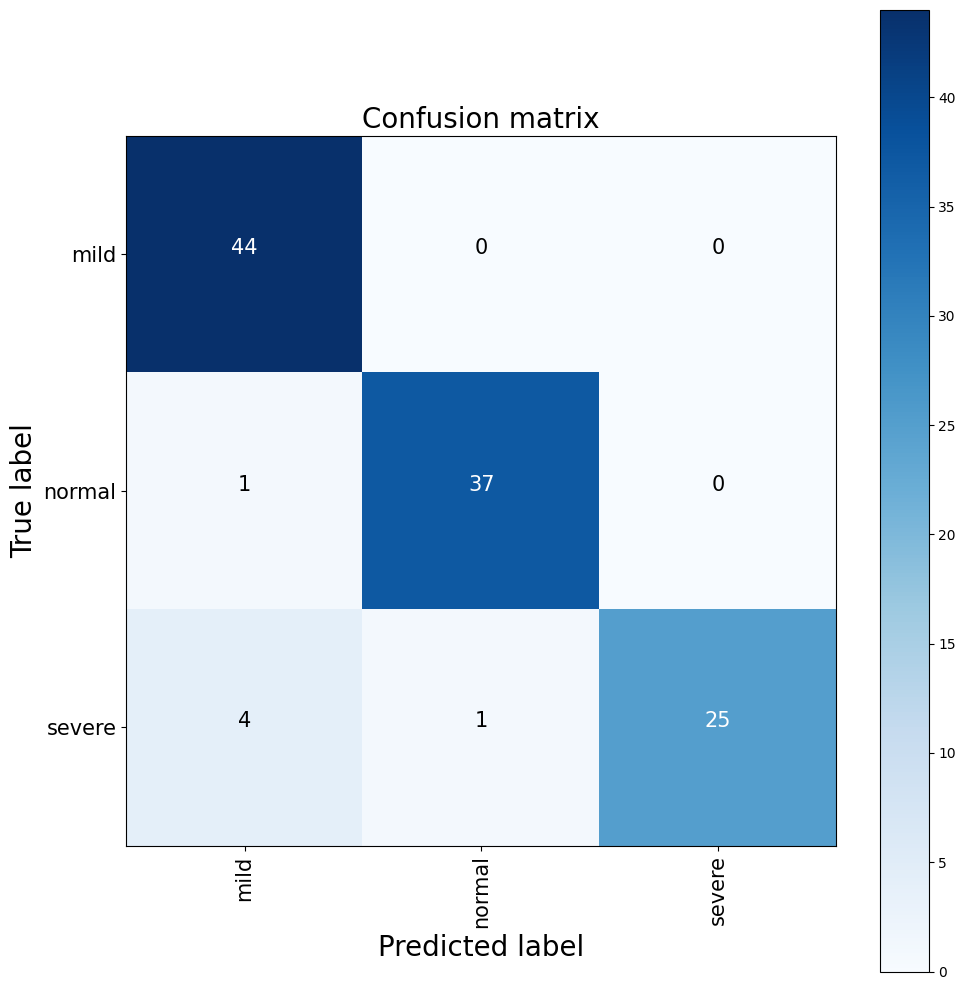

In [ ]:
show_confusion_matrix(conf_mat, class_names)

### Test With Cataract Dataset

In [ ]:
# Predict Sequential
predict_model = keras.Sequential([
    model,
    keras.layers.Softmax()
])

In [ ]:
# Predict with Real Cataract Image
for filename in os.listdir(TEST_PREDICT_DIR):
    img = keras.preprocessing.image.load_img(TEST_PREDICT_DIR + filename, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = predict_model.predict(img_array)

    score = tf.nn.softmax(predictions[0])

    print(filename)
    print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))
    print(predictions)

1/1 [==============================] - 0s 108ms/step
katarak_matur1.jpg
This image most likely belongs to mild with a 45.69 percent confidence.
[[0.686651   0.29489675 0.01845225]]
1/1 [==============================] - 0s 17ms/step
katarak-matur3.jpg
This image most likely belongs to normal with a 57.61 percent confidence.
[[1.5810807e-05 9.9998415e-01 5.9376536e-08]]
1/1 [==============================] - 0s 16ms/step
katarak_matur2.png
This image most likely belongs to mild with a 41.97 percent confidence.
[[0.5795504  0.18310295 0.23734663]]
